# Task 3: Customer Segmentation / Clustering

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from joblib import parallel_backend
from sklearn.cluster import MiniBatchKMeans
import numpy as np

In [26]:
# Force single-threaded operation
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["USE_MKL"] = "False"

In [19]:
customers = pd.read_csv("./datasets/Customers.csv")
products = pd.read_csv("./datasets/Products.csv")
transactions = pd.read_csv("./datasets/Transactions.csv")

Merging datasets for customer-level aggregation


In [20]:
customer_transactions = pd.merge(transactions, customers, on='CustomerID')
data = pd.merge(customer_transactions, products, on='ProductID')

Aggregating transaction data per customer

In [21]:
customer_features = data.groupby('CustomerID').agg({
    'Region': lambda x: x.mode()[0],
    'Category': lambda x: x.mode()[0],
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

Encoding categorical features and standardizing numerical features.

In [34]:
customer_features_encoded = pd.get_dummies(customer_features, columns=['Region', 'Category'])

scaler = StandardScaler()
numerical_cols = ['TotalValue', 'Quantity']
customer_features_encoded[numerical_cols] = scaler.fit_transform(customer_features_encoded[numerical_cols])

In [31]:
import warnings
warnings.filterwarnings('ignore')


### Determining the optimal number of clusters using the Elbow Method

In [35]:
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=4096)  # Set batch_size to 4096
    kmeans.fit(customer_features_encoded.iloc[:, 1:])
    inertia.append(kmeans.inertia_)

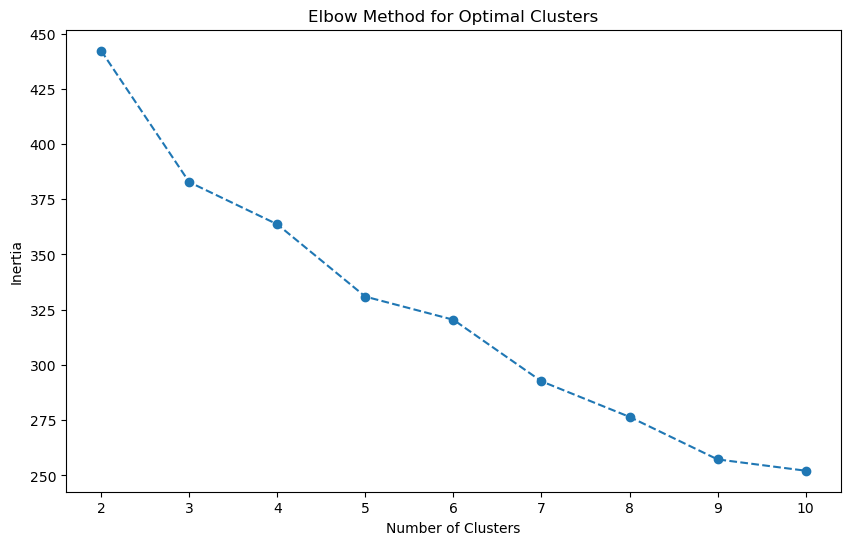

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

Choosing optimal clusters

In [37]:
optimal_clusters = 4
kmeans = MiniBatchKMeans(n_clusters=optimal_clusters, random_state=42, n_init=10, batch_size=4096)  
customer_features_encoded['Cluster'] = kmeans.fit_predict(customer_features_encoded.iloc[:, 1:])

Calculating DB Index

In [38]:
db_index = davies_bouldin_score(customer_features_encoded.iloc[:, 1:-1], customer_features_encoded['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.87711729178574


### Visualizing Clusters (for 2D Projection)

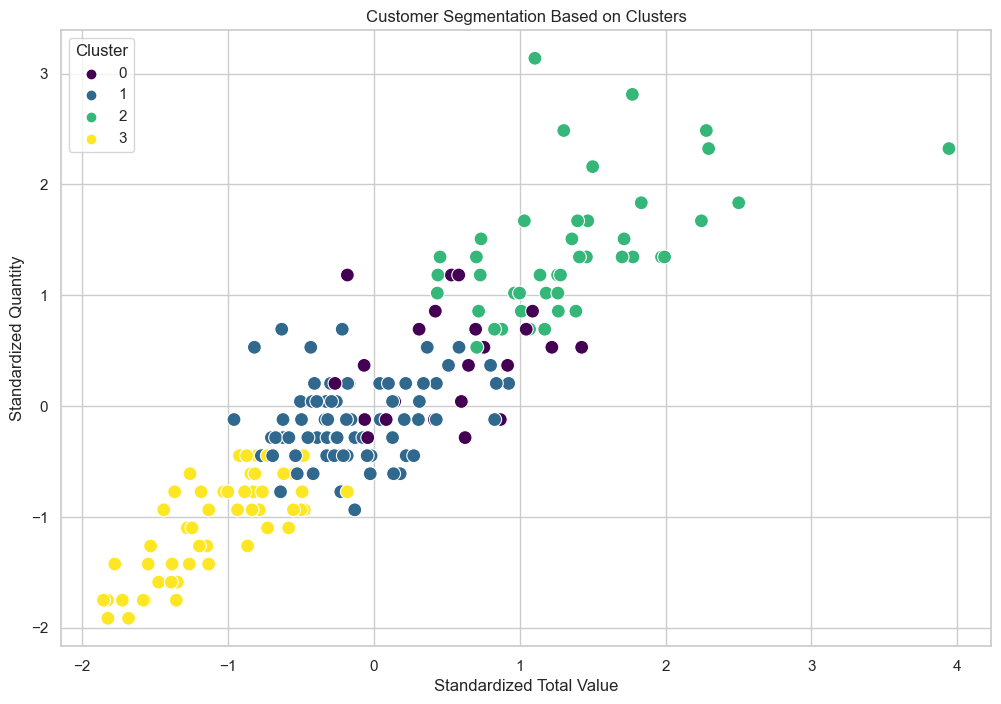

In [39]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=customer_features_encoded['TotalValue'], 
    y=customer_features_encoded['Quantity'], 
    hue=customer_features_encoded['Cluster'], 
    palette="viridis", 
    s=100
)
plt.title("Customer Segmentation Based on Clusters")
plt.xlabel("Standardized Total Value")
plt.ylabel("Standardized Quantity")
plt.legend(title="Cluster")
plt.show()

## Summary of Clusters

In [45]:
numeric_cols = customer_features_encoded.select_dtypes(include=[np.number]).columns
cluster_summary = customer_features_encoded.groupby('Cluster')[numeric_cols].mean()

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
         TotalValue  Quantity  Cluster
Cluster                               
0          0.508887  0.386476      0.0
1         -0.135642 -0.117568      1.0
2          1.364853  1.420626      2.0
3         -1.060500 -1.071834      3.0


Saving results

In [47]:
customer_features_encoded.to_csv("Anand_Gupta_Clustering.csv", index=False)

In [48]:
print("Clustering task completed. Results saved to Anand_Gupta_Clustering.csv.")

Clustering task completed. Results saved to Anand_Gupta_Clustering.csv.
